In [1]:
from time import time

import numpy as np

import keras
import tensorflow as tf
import tensorflow_probability as tfp

import matplotlib.pyplot as plt

plt.style.use('default')
%config InlineBackend.figure_format='retina'

tfd = tfp.distributions
tfb = tfp.bijectors

### Create Data

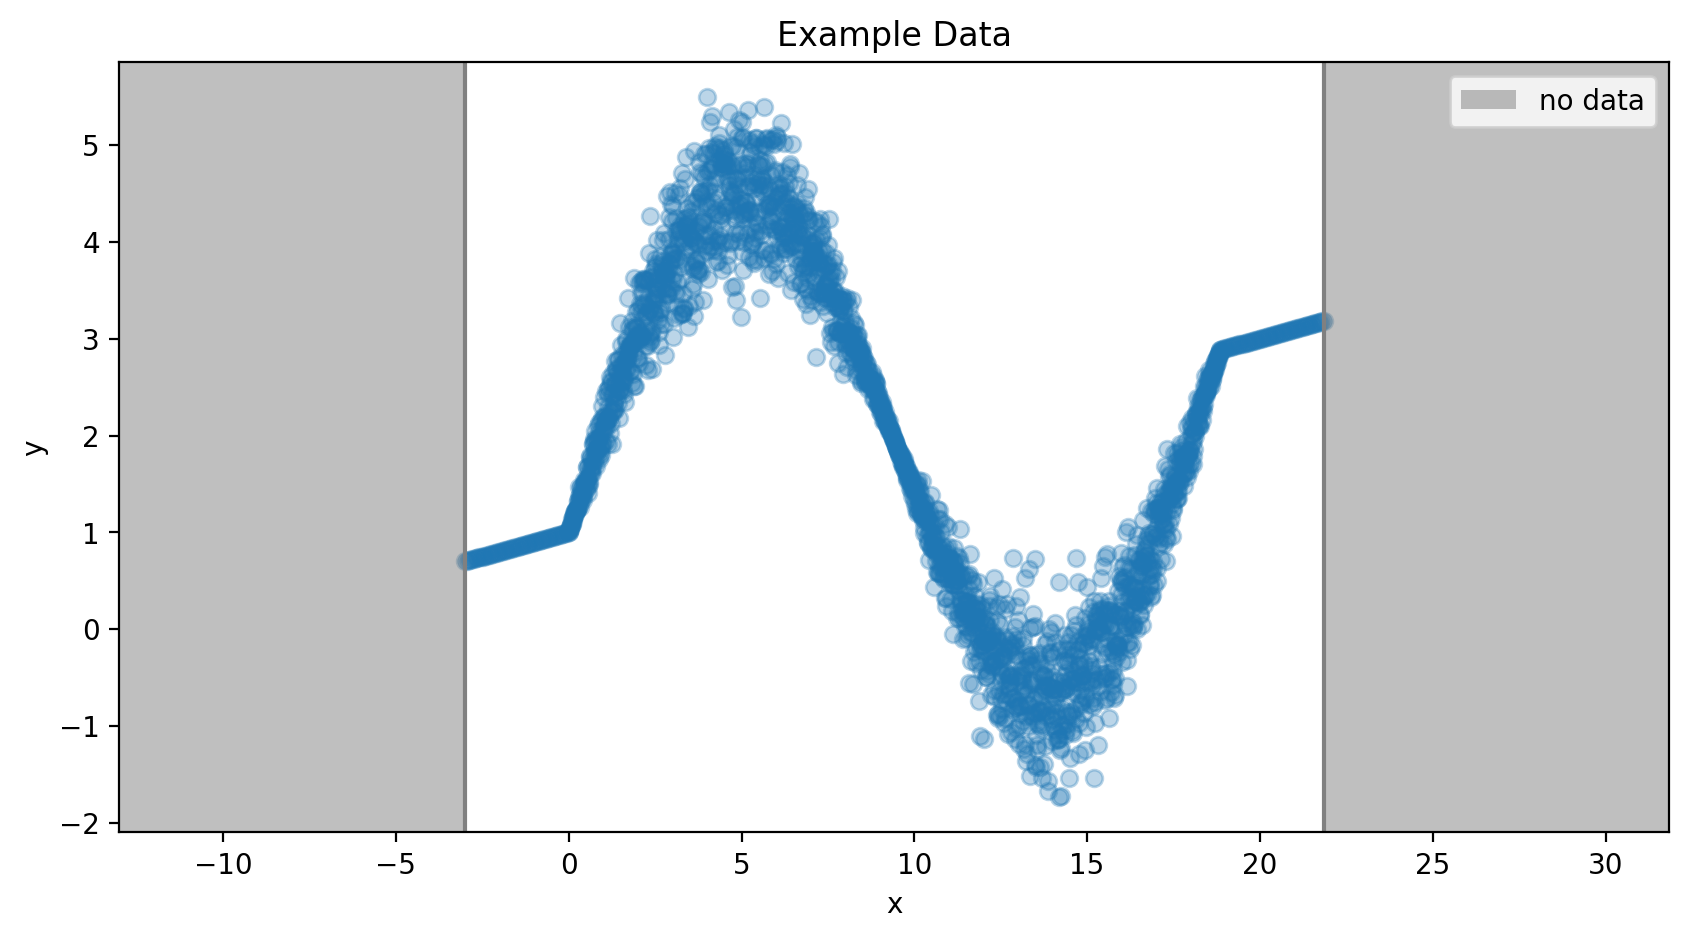

In [153]:

def create_sin_data(n = 2048):
    np.random.seed(32)
    x = np.linspace(0, 1 * 2 * np.pi, n)
    y1 = 3 * np.sin(x)
    y1 = np.concatenate(
        (
            np.zeros(60), 
            y1 + np.random.normal(0,0.15 * np.abs(y1), n),
            np.zeros(60)
        )
    )
    x = np.concatenate(
        (
            np.linspace(-3, 0, 60),
            np.linspace(0, 3 * 2 * np.pi, n),
            np.linspace(3 * 2 * np.pi, 3 * 2 * np.pi + 3, 60)
        )
    )
    y2 = 0.1 * x + 1
    y = y1 + y2
    return x, y

x, y = create_sin_data(2048) 
x_space_min = x.min() - 10
x_space_max = x.max() + 10

def plot_observed_data(x, y):
    plt.figure(figsize=(10, 5))
    plt.scatter(x=x, y=y, alpha=0.3)
    plt.xlim(x_space_min, x_space_max)
    plt.axvline(x.min(), color='grey')
    plt.axvspan(x_space_min, x.min(), color='grey', alpha=0.5, lw=0)
    plt.axvline(x.max(), color='grey')
    plt.axvspan(x.max(), x_space_max, color='grey', alpha=0.5, lw=0, label='no data')

    plt.xlabel("x")
    plt.ylabel("y")
    plt.legend()

plot_observed_data(x, y)
plt.title('Example Data');

In [129]:
def NLL(y, distr): 
  return -distr.log_prob(y) 

# TODO: use whatever we are using in our implementation 
def normal_sp(params): 
  return tfd.Normal(loc=params[:,0:1], scale=1e-3 + tf.math.softplus(0.05 * params[:,1:2]))# both parameters are learnable

inputs = keras.layers.Input(shape=(1,))
hidden = keras.layers.Dense(20,activation="relu")(inputs)
hidden = keras.layers.Dense(50,activation="relu")(hidden)
hidden = keras.layers.Dense(20,activation="relu")(hidden)
params = keras.layers.Dense(2)(hidden)
dist = tfp.layers.DistributionLambda(normal_sp)(params) 

model_nobay = keras.Model(inputs=inputs, outputs=dist)
model_nobay.compile(keras.optimizers.Adam(), loss=NLL) 


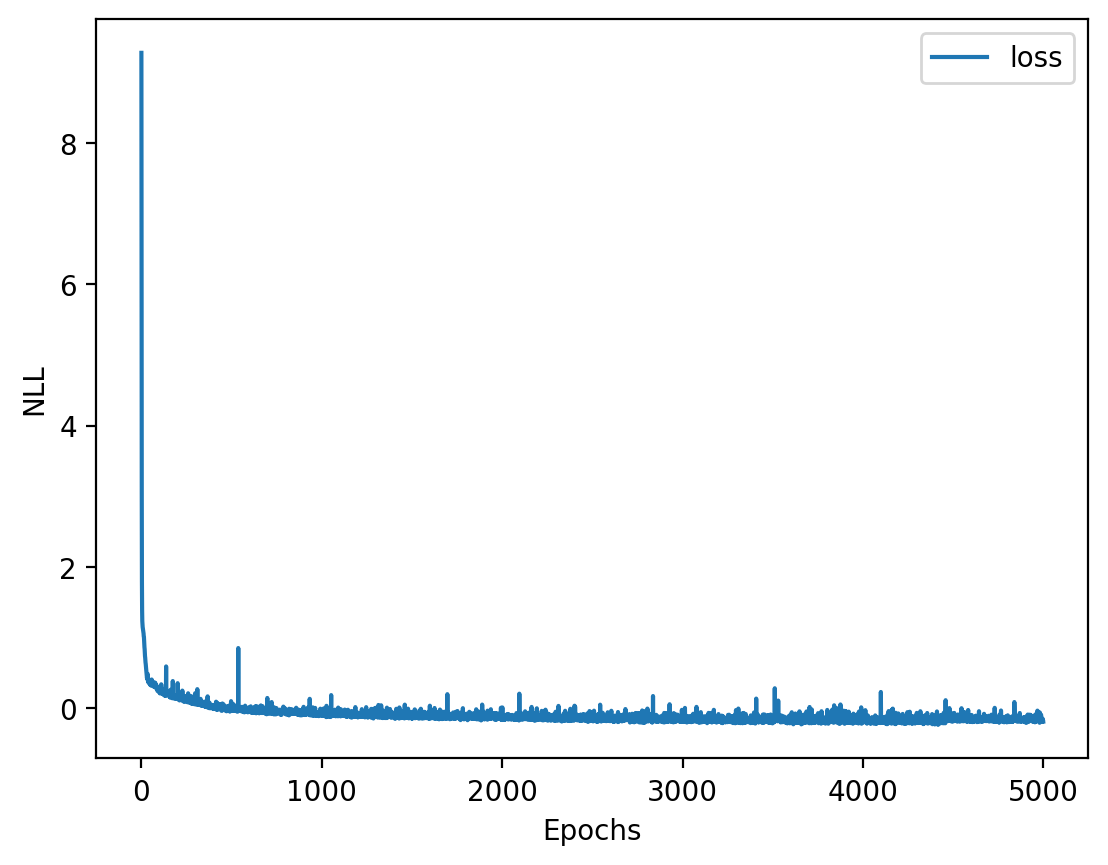

In [130]:
# Train
history = model_nobay.fit(x, y, verbose=0, epochs=5000, batch_size=32)

plt.plot(history.history['loss'])
plt.legend(['loss'])
plt.ylabel('NLL')
plt.xlabel('Epochs')
plt.show()

In [132]:
# Predict
x_input_space = np.arange(x_space_min, x_space_max, 0.1) 

runs = 200
nobay_cpd = np.zeros((runs, len(x_input_space)))
for i in range(0, runs):
    predictions = model_nobay.predict(x_input_space, verbose=0)
    nobay_cpd[i,:] = np.reshape(predictions, len(x_input_space))

In [133]:
def plot_learned_distribution(x, num_distributions=1):
    for i in range(0, num_distributions):
        if i == 0:
            plt.plot(x_input_space, nobay_cpd[i, :], color='red', alpha=0.5, zorder=2, label='Learned Function(s)')
        else:
            plt.plot(x_input_space, nobay_cpd[i, :], color='red', alpha=0.5, zorder=2)
        plt.legend()

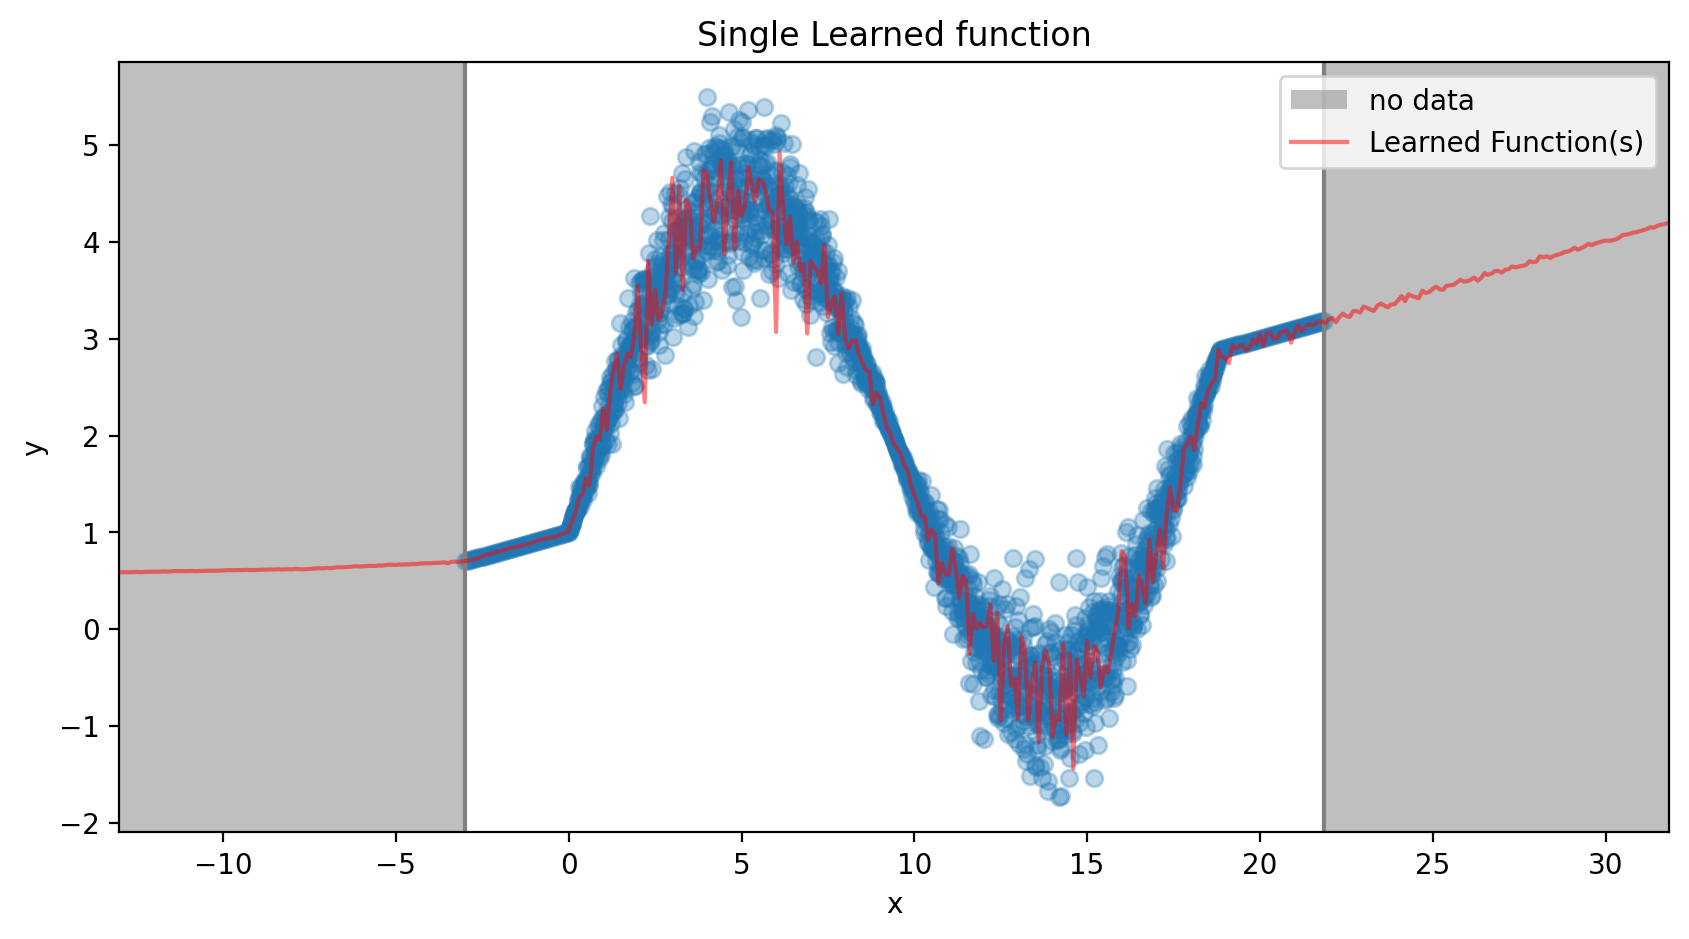

In [154]:
plot_observed_data(x, y)
plot_learned_distribution(nobay_cpd, num_distributions=1)
plt.title('Single Learned function');

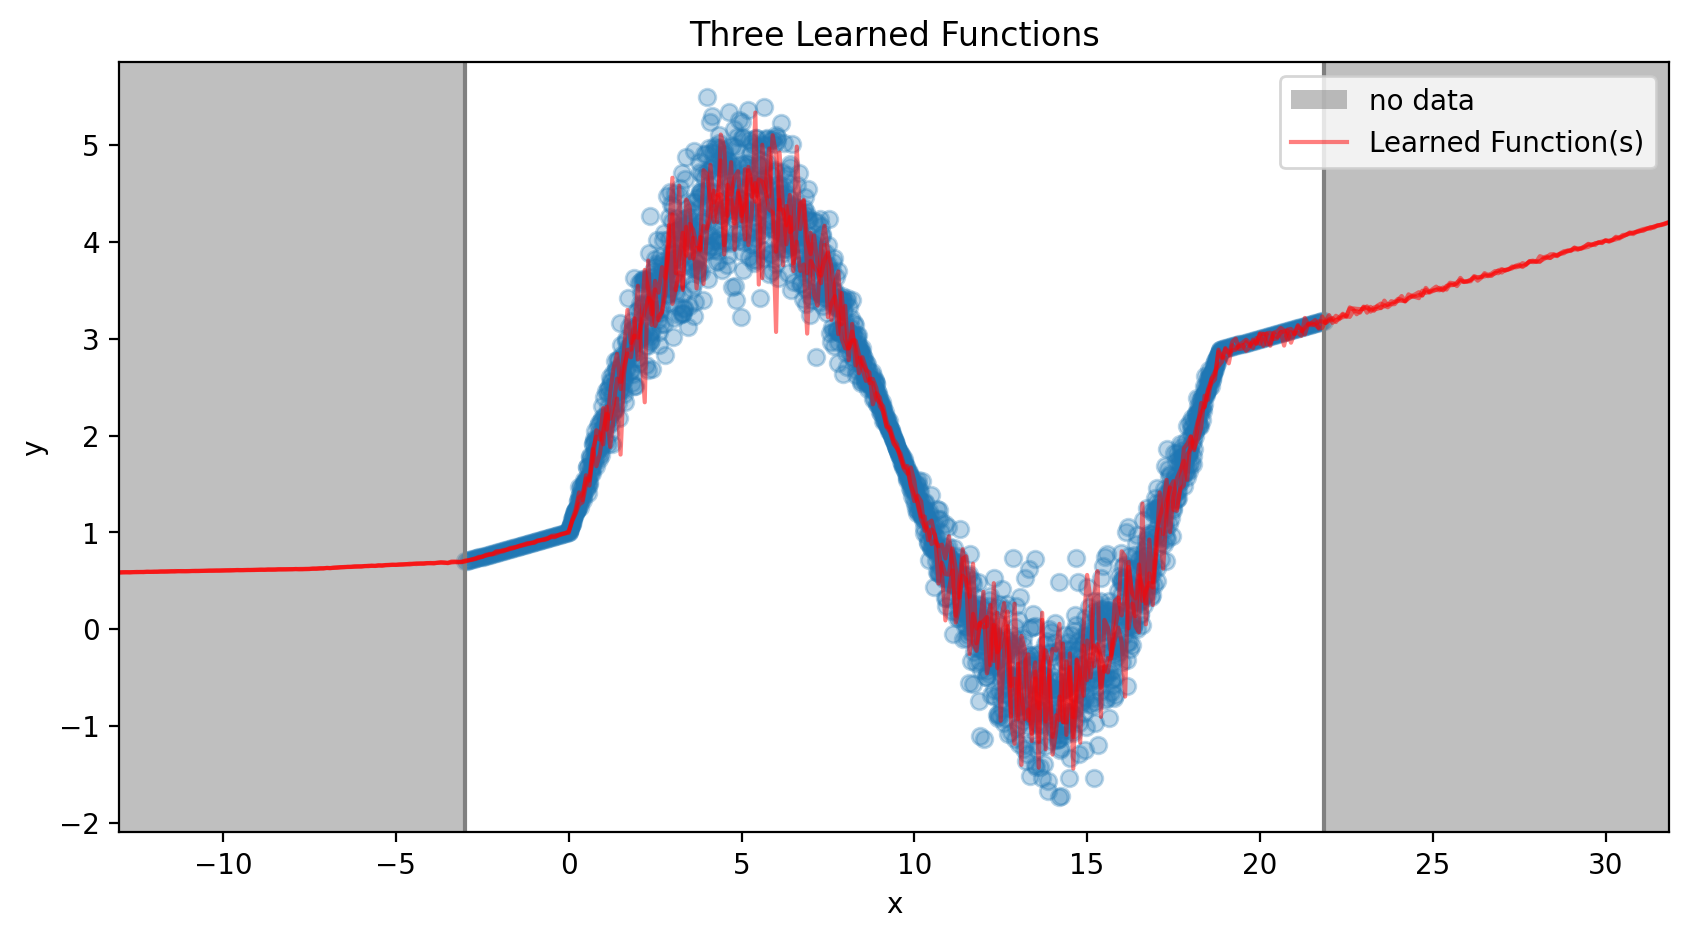

In [155]:
plot_observed_data(x, y)
plot_learned_distribution(nobay_cpd, num_distributions=3)
plt.title('Three Learned Functions');

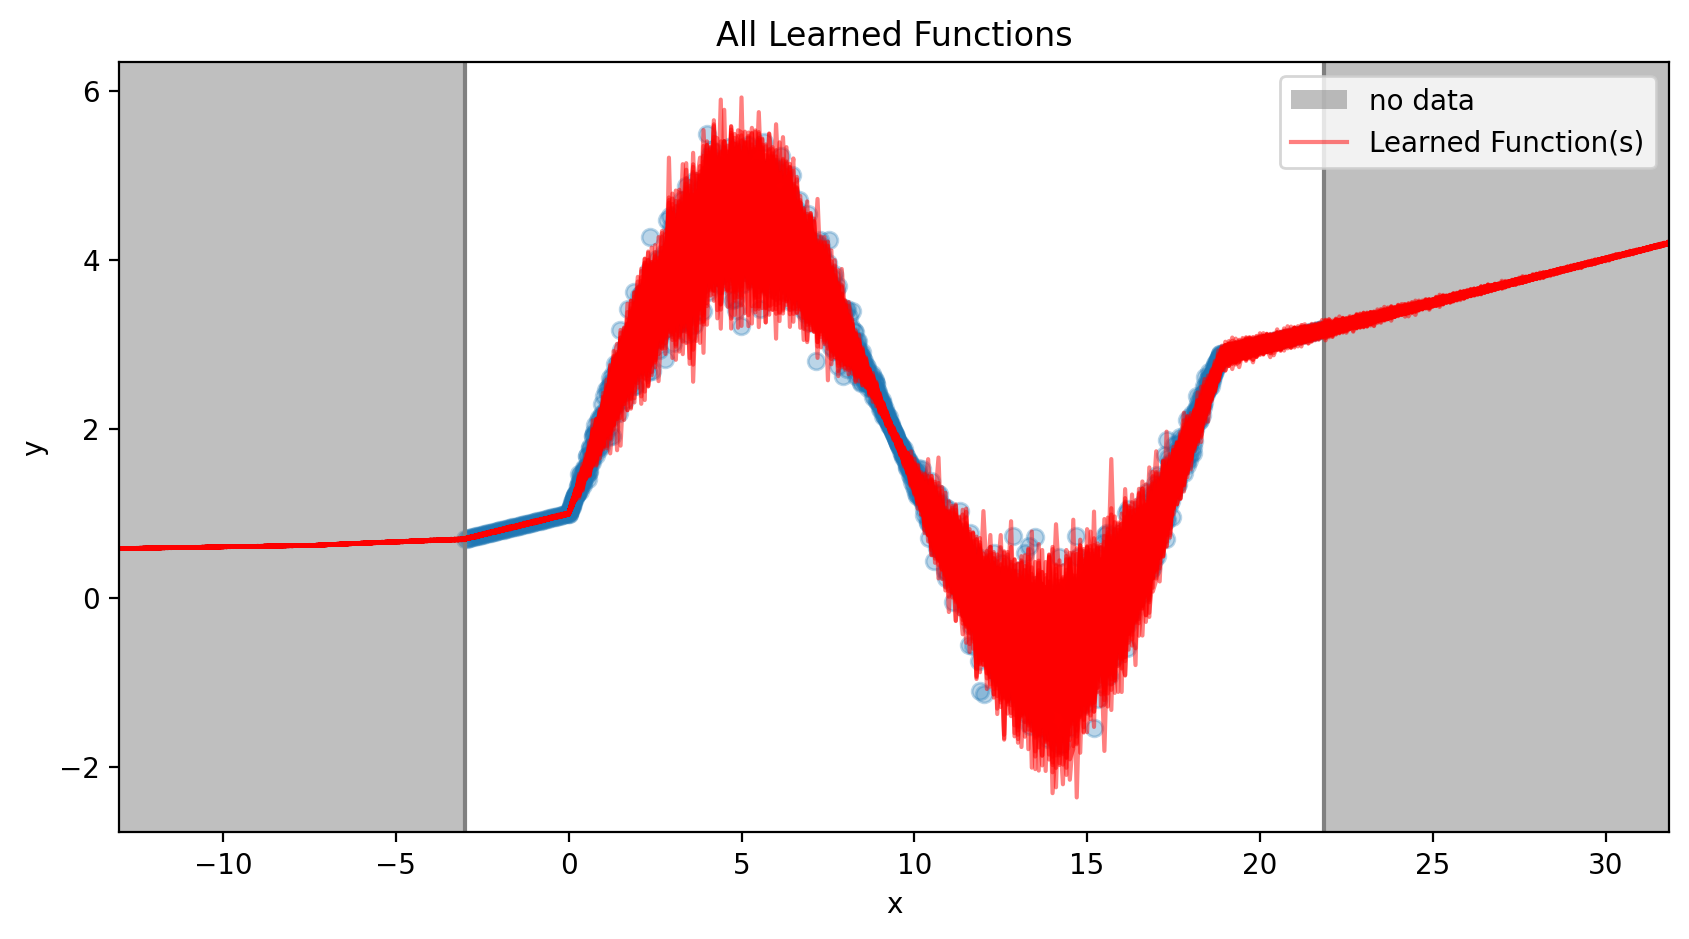

In [156]:
plot_observed_data(x, y)
plot_learned_distribution(nobay_cpd, num_distributions=nobay_cpd.shape[0])
plt.title('All Learned Functions');

In [137]:
def plot_learned_distribution_average(x):
    # Plot Mean (this is effectively what we would learn if we were just trying to predict a point estimate)
    plt.plot(x_input_space, np.mean(x, axis=0), color="black",linewidth=3, label='mean')

    # Plot confidence bounds (capturing aleatoric uncertainty)
    lower_bound = np.quantile(x, 0.025, axis=0)
    upper_bound = np.quantile(x, 0.975, axis=0)
    plt.plot(x_input_space, lower_bound, color="red",linewidth=1.5,linestyle="--", label='lower bound (2.5%)')
    plt.plot(x_input_space, upper_bound, color="red",linewidth=1.5,linestyle="--", label='upper bound (97.5%)')
    plt.fill_between(x_input_space, lower_bound, upper_bound, color='red', alpha=0.2)

    plt.legend()


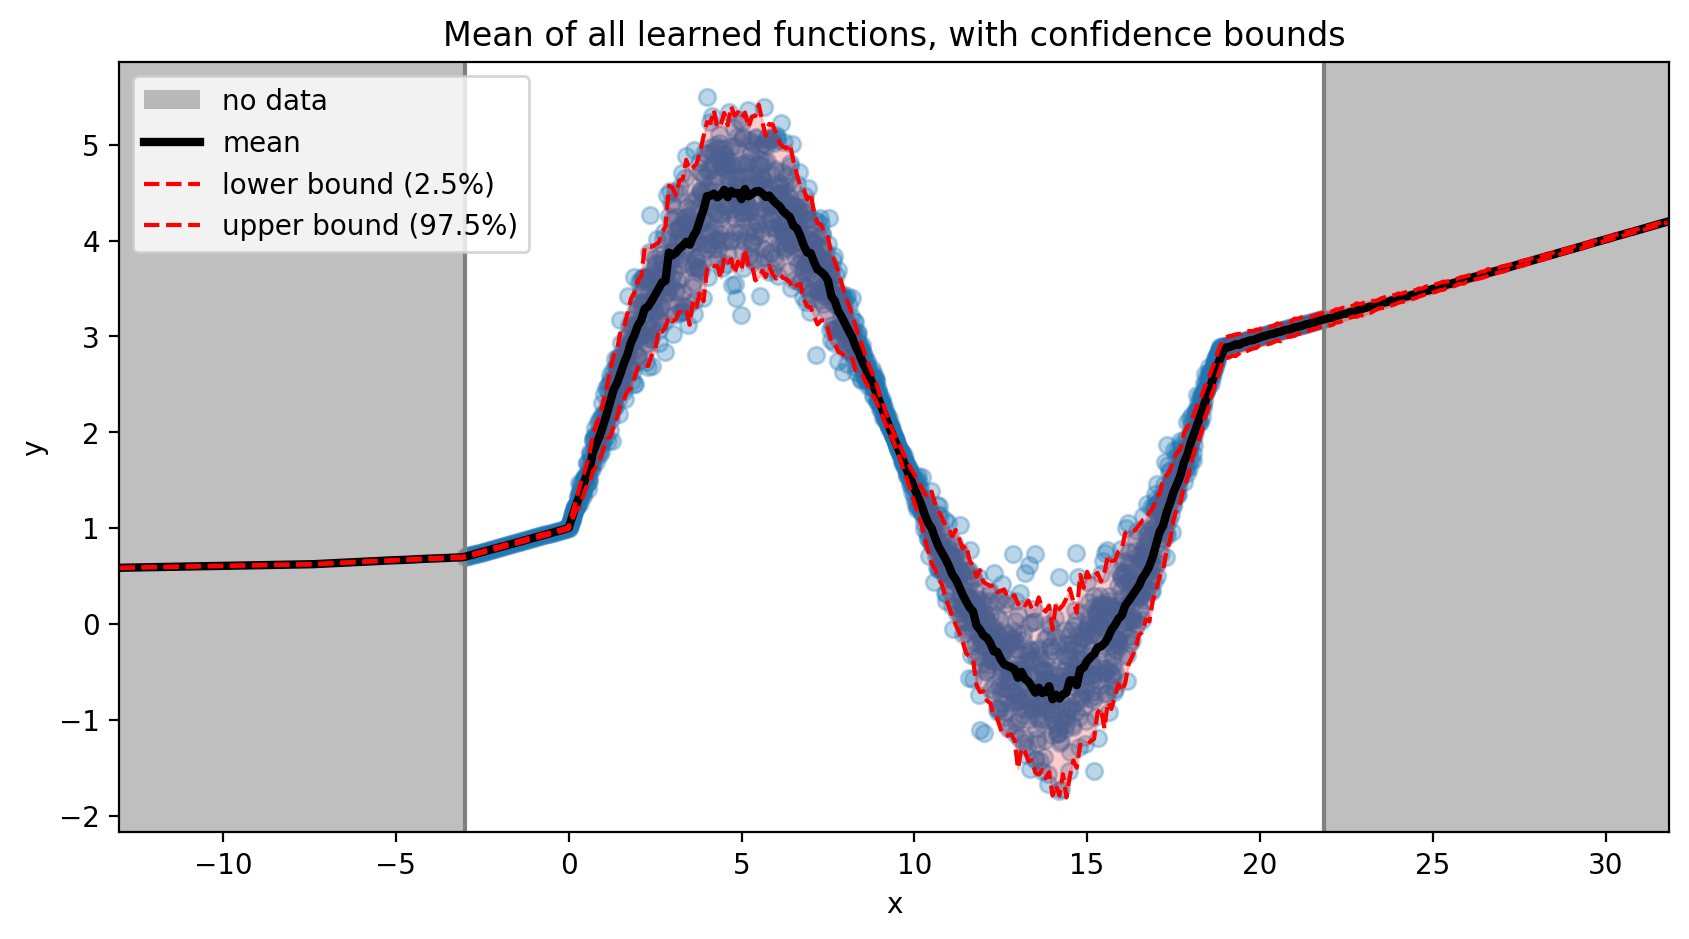

In [157]:
plot_observed_data(x, y)
plot_learned_distribution_average(nobay_cpd)
plt.title('Mean of all learned functions, with confidence bounds');

We see that in the region of **no data** our confidence bounds are incredibly tight. This is the exact opposite behavior of what we would like. Let's improve upon that.

### Variational Inference Model

In [140]:
kernel_divergence_fn=lambda q, p, _: tfp.distributions.kl_divergence(q, p) / (x.shape[0] * 1.0)
bias_divergence_fn=lambda q, p, _: tfp.distributions.kl_divergence(q, p) / (x.shape[0] * 1.0)


inputs = keras.layers.Input(shape=(1,))

hidden = tfp.layers.DenseFlipout(
    20,
    bias_posterior_fn=tfp.layers.util.default_mean_field_normal_fn(),
    bias_prior_fn=tfp.layers.default_multivariate_normal_fn,
    kernel_divergence_fn=kernel_divergence_fn,
    bias_divergence_fn=bias_divergence_fn,activation="relu"
)(inputs)

hidden = tfp.layers.DenseFlipout(
    50,
    bias_posterior_fn=tfp.layers.util.default_mean_field_normal_fn(),
    bias_prior_fn=tfp.layers.default_multivariate_normal_fn,
    kernel_divergence_fn=kernel_divergence_fn,
    bias_divergence_fn=bias_divergence_fn,activation="relu"
)(hidden)

hidden = tfp.layers.DenseFlipout(
    20,
    bias_posterior_fn=tfp.layers.util.default_mean_field_normal_fn(),
    bias_prior_fn=tfp.layers.default_multivariate_normal_fn,
    kernel_divergence_fn=kernel_divergence_fn,
    bias_divergence_fn=bias_divergence_fn,activation="relu"
    )(hidden)

params = tfp.layers.DenseFlipout(
    2,
    bias_posterior_fn=tfp.layers.util.default_mean_field_normal_fn(),
    bias_prior_fn=tfp.layers.default_multivariate_normal_fn,
    kernel_divergence_fn=kernel_divergence_fn,
    bias_divergence_fn=bias_divergence_fn
)(hidden)

dist = tfp.layers.DistributionLambda(normal_sp)(params) 


model_vi = keras.Model(inputs=inputs, outputs=dist)
model_vi.compile(keras.optimizers.Adam(learning_rate=0.0002), loss=NLL) 

model_params = keras.Model(inputs=inputs, outputs=params)

time taken :  190.127


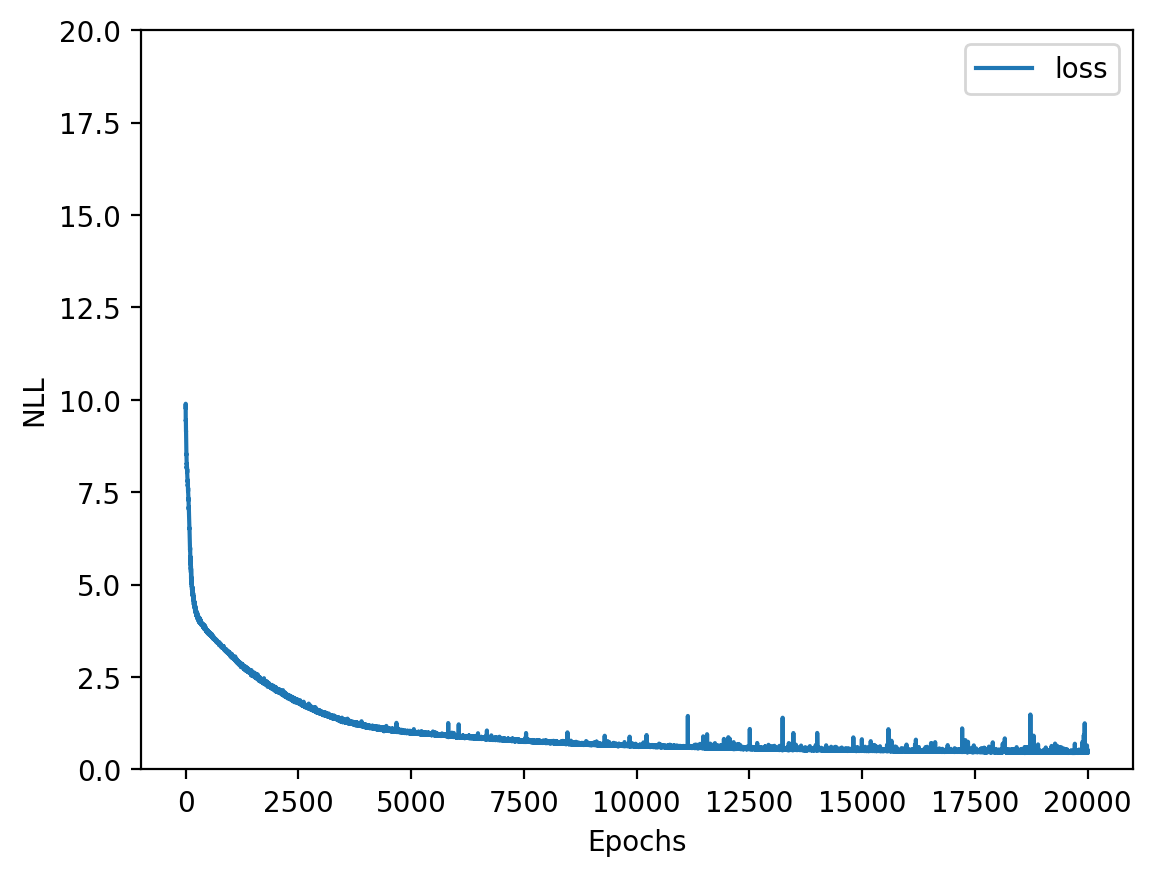

In [141]:
start = time()

history = model_vi.fit(x, y, epochs=20000, verbose=0, batch_size=512)

print('time taken : ', np.round(time() - start,3)) 

plt.plot(history.history['loss'])
plt.legend(['loss'])
plt.ylabel('NLL')
plt.xlabel('Epochs')
plt.ylim([0,20])

plt.show()

In [145]:
vi_cpd = np.zeros((runs,len(x_input_space)))
for i in range(0, runs):
    vi_cpd[i,:] = np.reshape(model_vi.predict(x_input_space, verbose=0), len(x_input_space))

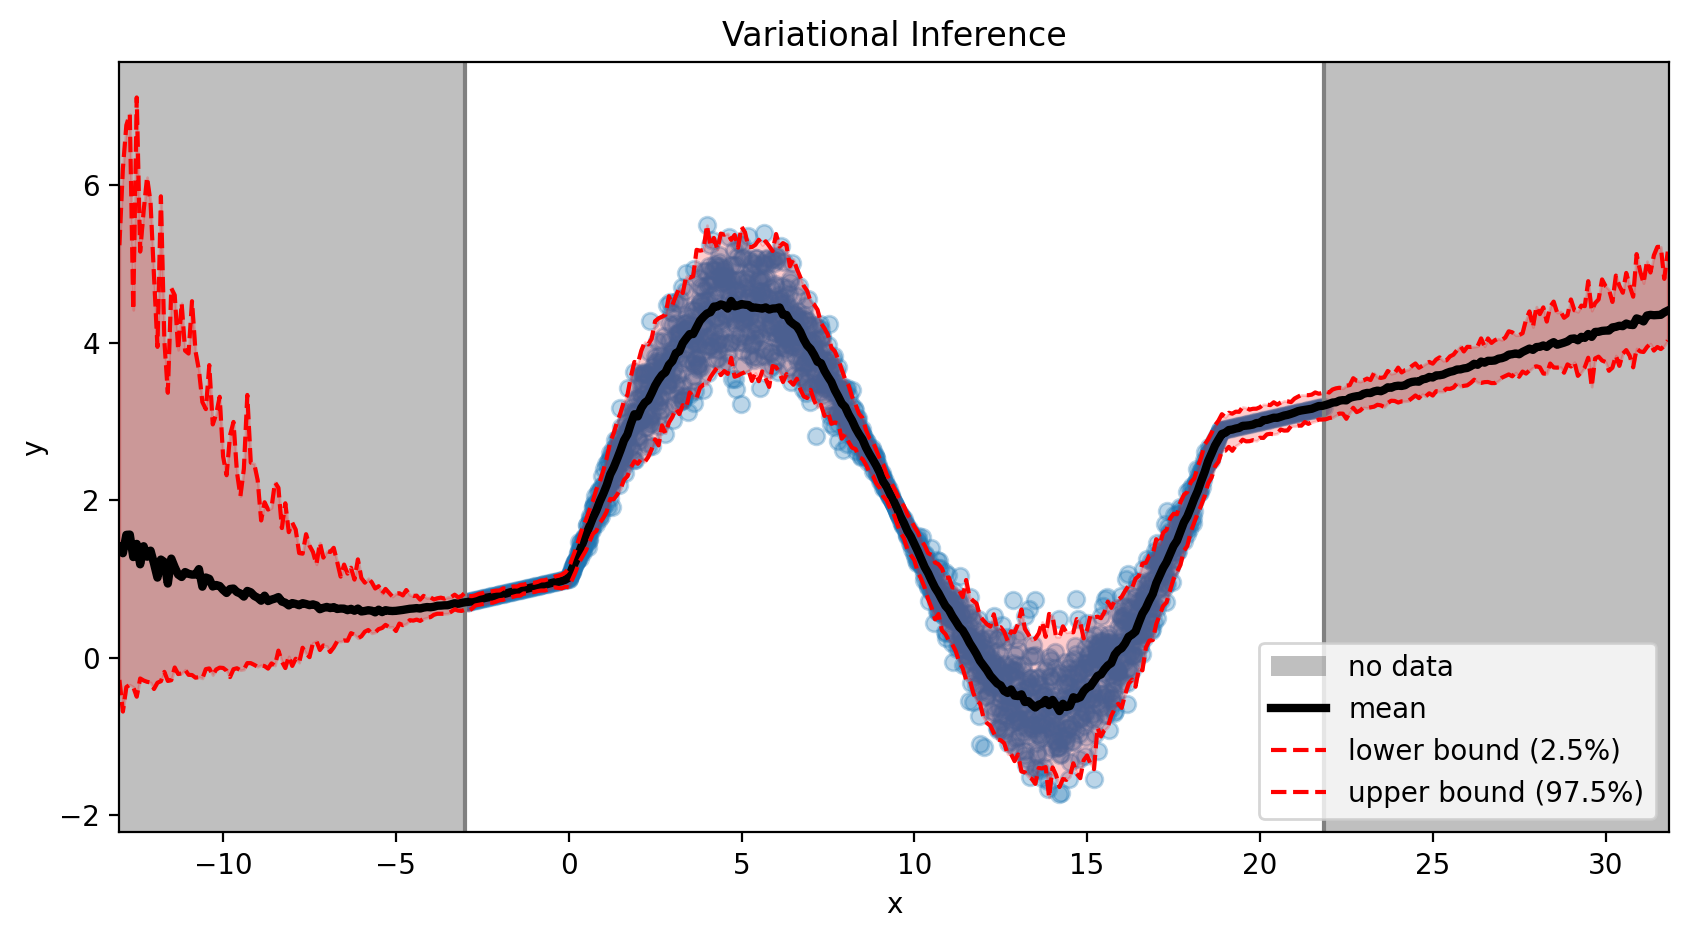

In [158]:
plot_observed_data(x, y)
plot_learned_distribution_average(vi_cpd)
plt.title('Variational Inference');

### MC Dropout

In [143]:
def normal_exp(params): 
  return tfd.Normal(loc=params[:, 0:1], scale=tf.math.exp(params[:, 1:2]))# both parameters are learnable


inputs = keras.layers.Input(shape=(1,))
hidden = keras.layers.Dense(200, activation="relu")(inputs)
hidden = keras.layers.Dropout(0.1)(hidden, training=True)
hidden = keras.layers.Dense(500, activation="relu")(hidden)
hidden = keras.layers.Dropout(0.1)(hidden, training=True)
hidden = keras.layers.Dense(500, activation="relu")(hidden)
hidden = keras.layers.Dropout(0.1)(hidden, training=True)
hidden = keras.layers.Dense(500, activation="relu")(hidden)
hidden = keras.layers.Dropout(0.1)(hidden, training=True)
hidden = keras.layers.Dense(200, activation="relu")(hidden)
hidden = keras.layers.Dropout(0.1)(hidden, training=True)
params_mc = keras.layers.Dense(2)(hidden)

dist_mc = tfp.layers.DistributionLambda(normal_exp, name='normal_exp')(params_mc) 

model_mc = keras.Model(inputs=inputs, outputs=dist_mc)
model_mc.compile(keras.optimizers.Adam(learning_rate=0.0002), loss=NLL) 

time taken :  43.709


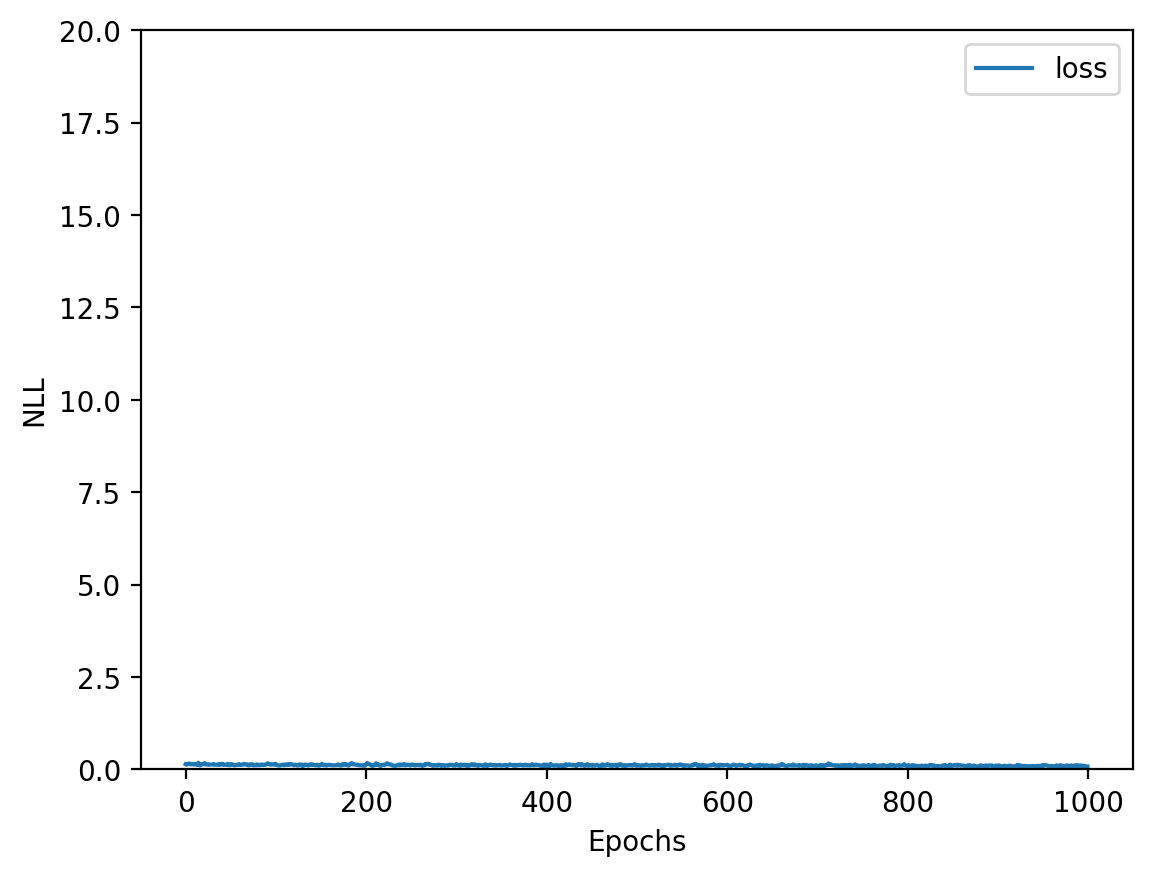

In [189]:
start = time()

history = model_mc.fit(x, y, epochs=1000, verbose=0, batch_size=512)

print('time taken : ', np.round(time() - start, 3))

plt.plot(history.history['loss'])
plt.legend(['loss'])
plt.ylabel('NLL')
plt.xlabel('Epochs')
plt.ylim([0, 20])
plt.show()

In [190]:
# Generate Predictions
mc_cpd = np.zeros((runs, len(x_input_space)))
for i in range(0,runs):
    mc_cpd[i, :] = np.reshape(model_mc.predict(x_input_space, verbose=0), len(x_input_space))

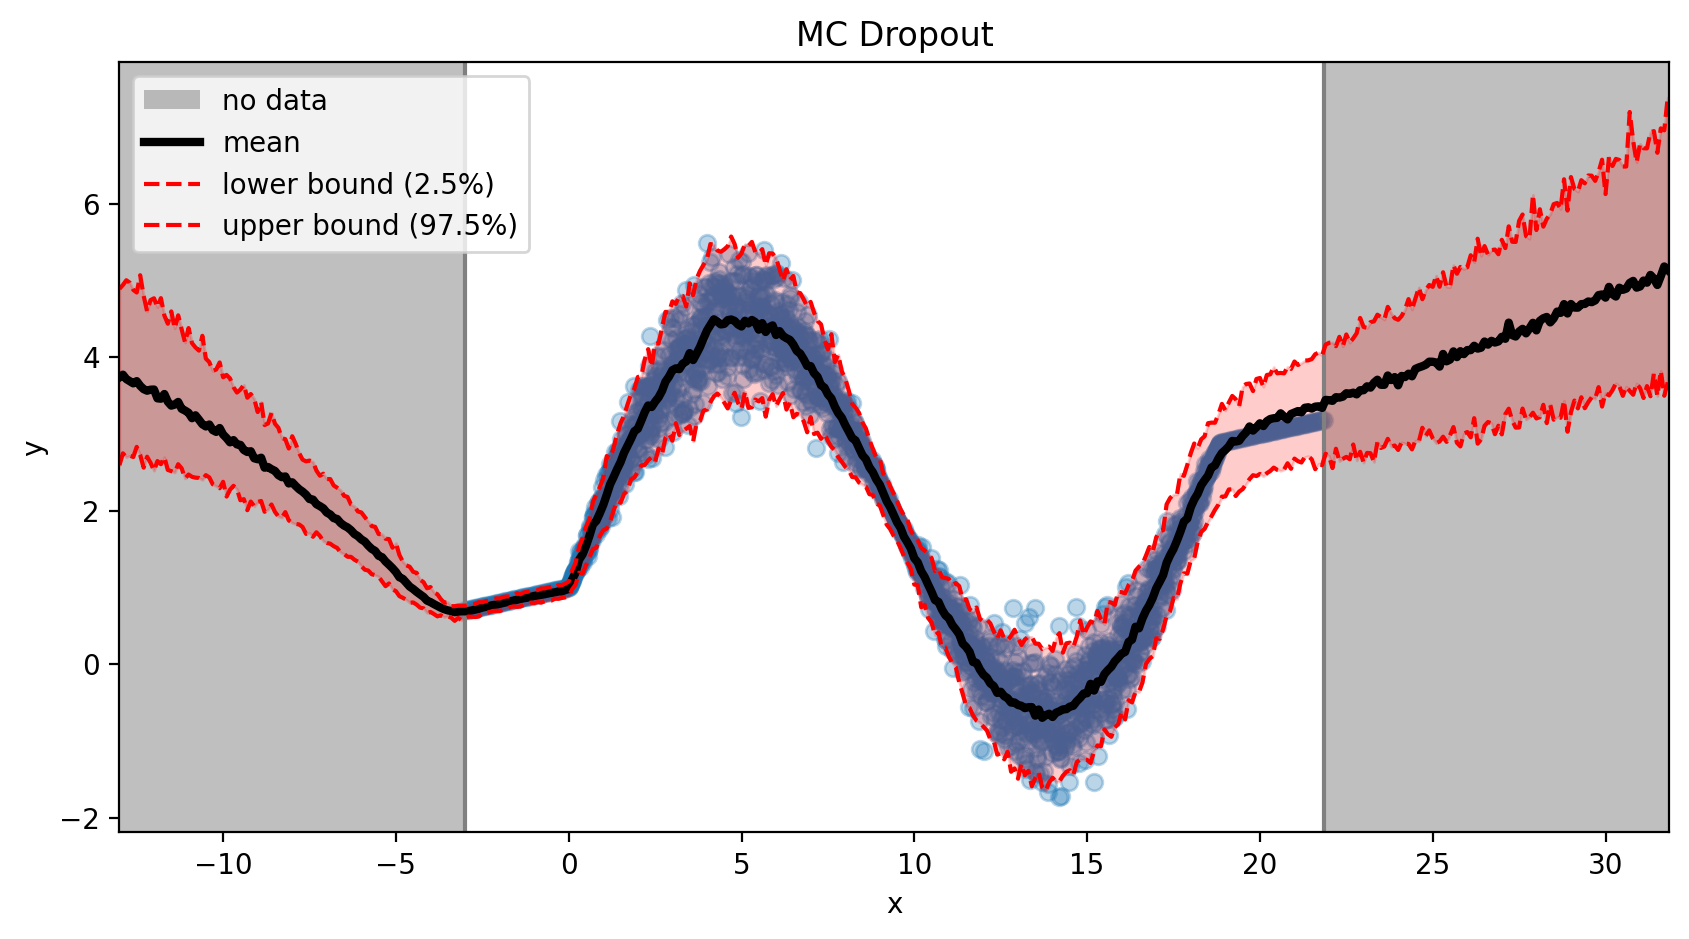

In [159]:
plot_observed_data(x, y)
plot_learned_distribution_average(mc_cpd)
plt.title('MC Dropout');

# Aleatoric vs. Epistemic Uncertainty 

In [284]:
runs = 200
cpd = np.zeros((runs, len(x_input_space)))
mean = np.zeros((runs, len(x_input_space)))
std = np.zeros((runs, len(x_input_space)))
var = np.zeros((runs, len(x_input_space)))

for i in range(0,runs):
    # cpd[i, :] = np.reshape(model_vi.predict(x_input_space, verbose=0),len(x_input_space))
    mean[i, :] = np.reshape(model_vi(x_input_space).mean(), len(x_input_space))
    std[i, :] = np.reshape(model_vi(x_input_space).stddev(), len(x_input_space))
    var[i, :] = np.reshape(model_vi(x_input_space).variance(), len(x_input_space))


In [272]:
def compute_aleatoric_vs_epistemic_uncertainty(index, mean, var):
    """See decomposition in this paper: https://arxiv.org/pdf/2204.09308.pdf (Eq 3...)"""
    mu = mean[:, index]
    mu_star = mu.sum() / len(mu)

    variance = var[:, index]

    # This can be decomposed into aleatoric and epistemic uncertainty
    sigma_square_star = (1 / len(variance)) * ((variance**2 + mu**2) - mu_star**2).sum()

    aleatoric_uncertainty = (1 / len(variance)) * (variance**2).sum()
    epistemic_uncertainty = (1 / len(variance)) * (mu**2 - mu_star**2).sum()

    return aleatoric_uncertainty, epistemic_uncertainty


In [292]:
compute_aleatoric_vs_epistemic_uncertainty(0, mean, var) # No data

(0.005600041668721947, 3.347340368855778)

In [298]:
compute_aleatoric_vs_epistemic_uncertainty(180, mean, var) # Data

(0.035405066817193846, 0.0028569367102119258)

In [299]:
compute_aleatoric_vs_epistemic_uncertainty(-1, mean, var) # No data

(5.1620556021575954e-08, 0.2572244872088132)

In [313]:
compute_aleatoric_vs_epistemic_uncertainty(350, mean, var) # No data

(1.8364743313770905e-05, 0.0032854077127170457)

In [304]:
aleatoric_uncertainties = []
epistemic_uncertainties = []
for i in range(0, mean.shape[1]):
    a, e = compute_aleatoric_vs_epistemic_uncertainty(i, mean, var)
    aleatoric_uncertainties.append(a)
    epistemic_uncertainties.append(e)